In [1]:
from scipy.special   import erfc
from scipy.special   import hyp2f1

from scipy.special import *
import scipy.special as sc_sp
from mpmath import *
from mpmath import mp
from scipy.integrate import cumtrapz
from math import *
from scipy.constants import c
import matplotlib.gridspec as gridspec
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
na=np.array
mp.dps = 20;
#%run -i noiseINmodel_new.ipynb

In [2]:
# parameters
#----------------------------
sigma_inelastic_m2 = 81e-31
#----------------------------
Nrj                = 6500.0    # GeV 
Mproton            = 0.93827231
gama              = Nrj/Mproton
print gama
circum             = 26658.8832
clight             = 299792458.0
frev               = clight/circum;
#----------------------------
Npart              = 1.1e11
nb                 = 1. #so that to have the per bunch, otherwise give a number #2748  # Gianni suggestion 2492b
bx                 = 0.4
by                 = 0.4
enx                = 2.0e-6
eny                = 2.0e-6
xing               = 160.0e-6
minXing            = 160.0e-6
bstar_init         = 0.4  # 1m
bstar_min          = 0.4 # 25cm
bstar_max          = 0.4 # 1m
changeXing         = False
phi                = 2.0*xing
minPhi             = 2.0*minXing
smoothXing         = None #2.0e-6
blength            = 1.10e-9 # 4sigma bl
levelBunchLength   = None #1.0e-9 # else None
blength_Init       = blength # else None

6927.6263732


In [3]:
frev

11245.499511397387

In [17]:
# Define Gaussian Luminosity
def luminosity(gama=None, bx_m=None, by_m=None, enx_m=None, eny_m=None, Npart_ppb=None, nb=None, frev_hz=None, blength_s=None, phi_rad=None, experiment=None, crab=False):    

    clight = 299792458.0
    # some conversions
    xing_rad    = phi_rad/2.0
    sigz        = (blength_s/4.0)*clight
    #print sigz
    emitGeo_x_m = enx_m/gama
    emitGeo_y_m = eny_m/gama
    
    # Calculate Hourglass
    u_fact    = bx_m/(sigz)
    Hourglass = np.sqrt(np.pi)*u_fact*np.exp(u_fact**2)*erfc(u_fact) 
    #print '~~',u_fact,Hourglass
    # Calculate Beam size squared 
    beam_size_x=np.sqrt(bx_m*emitGeo_x_m)
    beam_size_y=np.sqrt(by_m*emitGeo_y_m)
    beam_size = beam_size_x*beam_size_y
    # Calculate Kernel
    FF = (Npart_ppb*Npart_ppb*nb*frev_hz)/(4*np.pi*beam_size)

    # Calculate Geometric Factor, depending on crossing plane
    if experiment is None:
        experiment = "CMS"
        
    if experiment == 'ATLAS':
        S  = 1/np.sqrt(1+ ((sigz*xing_rad)**2)/beam_size_y**2.0 )
    elif experiment == 'CMS':
        
        S  = 1/np.sqrt(1+ ((sigz*xing_rad)**2)/beam_size_x**2.0 )
    
    # Return Luminosity with crab cavities (R1/R0 ?)
    if crab:
        R1  = 0.8
        R0  = 0.285
        C   = R1/R0
        return FF*S*Hourglass*C
    
    #print beam_size_x, beam_size_y, blength
    #print 'FF:',FF, 'Hourglass:',Hourglass, 'S:',S
    return FF#*S#*Hourglass

In [18]:
#Gaussian luminosity for the beam parameters defined earlier
pLumi = luminosity(gama=gama, bx_m=bx, by_m=bx, enx_m=enx, eny_m=eny, Npart_ppb=Npart, nb=nb, frev_hz=frev, blength_s=blength, phi_rad=phi, experiment='CMS', crab=False)
print("-- Peak Luminosity [Hz/m^2] : {:.5f}".format(pLumi/1.0e34))
#print("-- Peak pileup     [|events] : {:.5f}".format(mutot(gamma=gamma, bx_m=bx, by_m=by, Npart_ppb=Npart, enx_m=enx, eny_m=eny, nb=nb, blength_s=blength, phi_rad=phi, xsect_inel_msq=sigma_inelastic_m2, frev_hz=frev, lumi_hzInvMsq=pLumi, llev_hzInvMsq=None, experiment='ATLAS', crab=False)))

-- Peak Luminosity [Hz/m^2] : 9.37667


In [54]:
# Define q-Gaussian Luminosity, after solving the lumi integrals

def luminosity_3DqGauss(qx=None,qy=None,qz=None, bbx=None,bby=None,bbz=None, Npart_ppb=None, nb=None, frev_hz=None, phi_rad=None):    

    xing_rad= phi_rad/2.0

    if qx<1:
        normFactorX=2.*sqrt(pi)*mp.gamma(1./(1-qx))/((3-qx)*sqrt(1-qx)*mp.gamma((3-qx)/(2.*(1-qx))))
        intX=sqrt(pi)*mp.gamma((-3+qx)/(-1+qx))/(sqrt(bbx*(1-qx))*mp.gamma(3./2.-2./(-1+qx)))
    elif qx==1:
        normFactorX=sqrt(pi) 
        intX=sqrt(pi)*mp.gamma(-1./2.+2./(-1+qx))/(sqrt(bbx*(-1+qx))*mp.gamma(2./(qx-1)))
    elif qx>1 and qx<3: 
        normFactorX=sqrt(pi)*mp.gamma((3-qx)/(2.*(qx-1)))/(sqrt(qx-1)*mp.gamma(1./(qx-1)))
        intX=sqrt(pi)*mp.gamma(-1./2.+2./(-1+qx))/(sqrt(bbx*(-1+qx))*mp.gamma(2./(qx-1)))
        
    if qy<1:
        normFactorY=2.*sqrt(pi)*mp.gamma(1./(1-qy))/((3-qy)*sqrt(1-qy)*mp.gamma((3-qy)/(2.*(1-qy))))
        intY=sqrt(pi)*mp.gamma((-3+qy)/(-1+qy))/(sqrt(bby*(1-qy))*mp.gamma(3./2.-2./(-1+qy)))
    elif qy==1:
        normFactorY=sqrt(pi)
        intY=sqrt(pi)*mp.gamma(-1./2.+2./(-1+qy))/(sqrt(bby*(-1+qy))*mp.gamma(2./(qy-1)))
    elif qy>1 and qy<3:    
        normFactorY=sqrt(pi)*mp.gamma((3-qy)/(2.*(qy-1)))/(sqrt(qy-1)*mp.gamma(1./(qy-1)))
        intY=sqrt(pi)*mp.gamma(-1./2.+2./(-1+qy))/(sqrt(bby*(-1+qy))*mp.gamma(2./(qy-1)))
        
    if qz<1:
        normFactorZ=2.*sqrt(pi)*mp.gamma(1./(1-qz))/((3-qz)*sqrt(1-qz)*mp.gamma((3-qz)/(2.*(1-qz))))
        intZ=sqrt(pi)*mp.gamma((-3+qz)/(-1+qz))/(sqrt(bbz*(1-qz))*mp.gamma(3./2.-2./(-1+qz)))
    elif qz==1:
        normFactorZ=sqrt(pi)
        intZ=sqrt(pi)*mp.gamma(-1./2.+2./(-1+qz))/(sqrt(bbz*(-1+qz))*mp.gamma(2./(qz-1)))
    elif qz>1 and qz<3:    
        normFactorZ=sqrt(pi)*mp.gamma((3-qz)/(2.*(qz-1)))/(sqrt(qz-1)*mp.gamma(1./(qz-1)))
        intZ=sqrt(pi)*mp.gamma(-1./2.+2./(-1+qz))/(sqrt(bbz*(-1+qz))*mp.gamma(2./(qz-1)))
        
    normfactors=(bbx/normFactorX**2)*(bby/normFactorY**2)*(bbz/normFactorZ**2) #it is ^2 because it's for both beams and f=(sqrt(b)/normFactor)*(1-b(1-q)x^2)^(1/(1-q))
    #print normfactors
    fxyz=intX*intY*intZ*normfactors#*aFactor
    fxy=intX*intY*(bbx/normFactorX**2)*(bby/normFactorY**2)
    #print 'for z:',intZ*(bbz/normFactorZ**2)/6
    # Calculate Kernel
    #print fxyz
    FF = (Npart_ppb*Npart_ppb*nb*frev_hz)*fxy#/(10.871)
    #print (bbz/normFactorZ**2),intZ
    #print 'FF:',(Npart_ppb*Npart_ppb*nb*frev_hz)*intX*intY*(bbx/normFactorX**2)*(bby/normFactorY**2),'normZ*intZ:',(bbz/normFactorZ**2)*intZ
    #print 'intxz=',2*intX*intZ
    #print 'intx=',intX,'intz=',intZ
    #print '',(Npart_ppb*Npart_ppb*nb*frev_hz)*((bbx/normFactorX**2)*(bby/normFactorY**2)*intX*intY)#/(10.871)

    if qx<1:
        intf=sqrt(pi)*mp.gamma((-3+qx)/(-1+qx))/(sqrt((1-qx))*mp.gamma(3./2.-2./(-1+qx)))*(1/sqrt(5-3*qx)/normFactorX**2)
    elif qx>1 and qx<3: 
        intf=sqrt(pi)*mp.gamma(-1./2.+2./(-1+qx))/(sqrt((-1+qx))*mp.gamma(2./(qx-1)))*(1/sqrt(5-3*qx)/normFactorX**2)
        
    return FF, intf

In [59]:
#checking  if sigmas, bunch length and luminsoity are the same when we set q=1, 
#that should give exactly the same results as the Gaussian'

clight = 299792458.0
sigma_G=np.sqrt(bx*enx/gama)
qq=1.006
bbx_g=4369078278
bby_g=bbx_g
bbz_g=74.231

bbx=bbx_g;bby=bbx;bbz=bbz_g;
print 'sigmas ratio=',np.sqrt(1./(bbx*(5.0-3.0*qq)))/sigma_G,'bunch lengths ratio=', np.sqrt(1./(bbz*(5.0-3.0*qq)))/(blength*clight/4.)

#print qq,bbx,bby
lll=luminosity_3DqGauss(qx=qq,qy=qq,qz=qq, bbx=bbx,bby=bby,bbz=bbz, Npart_ppb=Npart, nb=nb, frev_hz=frev, phi_rad=phi)
print 'lumis ratio (q-Gaussian for q=1 over the Gaussian)=', lll/pLumi, '(->should be ~1)'

sigmas ratio= 1.0000011443768995 bunch lengths ratio= 1.000004887434415
lumis ratio (q-Gaussian for q=1 over the Gaussian)= [mpf('1.0022752523193875757071') mpf('3.0118985632517653039934e-36')] (->should be ~1)


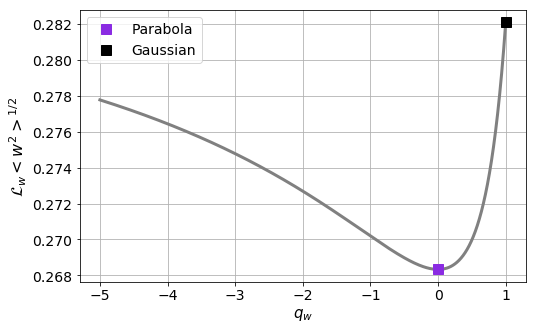

In [60]:
fig = plt.figure('', figsize=(8,5))

iix=[]
therange=np.arange(-5, 1.006, 0.01)
for qvar in therange:
    ix= luminosity_3DqGauss(qx=qvar,qy=qvar,qz=qq, bbx=bbx,bby=bby,bbz=bbz, Npart_ppb=Npart, nb=nb, frev_hz=frev, phi_rad=phi)[1]
    #intX=intX
    iix.append(ix)
    #print qvar
    
plt.plot(therange,na(iix),color='grey',Linewidth=3)
plt.plot(therange[500],na(iix)[500],'s',color='blueviolet',Markersize=10,label='Parabola')
plt.plot(therange[-1],na(iix)[-1],'sk',Markersize=10,label='Gaussian')
#plt.plot(np.arange(0, 1.66666, 0.011)[91],iix[91]/iix[91],'sk')
#plt.xlabel('q', fontsize=15)
#plt.ylabel('Integral variation', fontsize=15)

#plt.plot(xx, zz,'.', color='grey',Markersize=10, label='$\cal{L}$$^{qG}$')    
plt.legend(loc='upper left', fontsize=14, numpoints=1)
plt.ylabel('${\cal {L}}_w <w^2>^{1/2}$',fontsize=16)
plt.xlabel('$q_w$', fontsize=15)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.grid('on')    

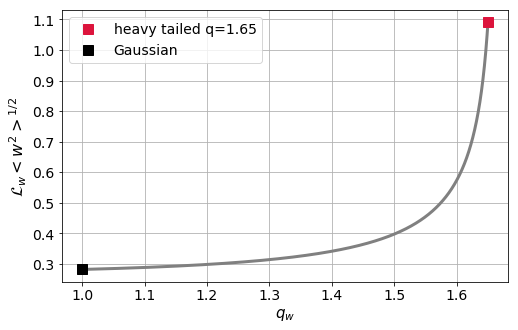

In [61]:
fig = plt.figure('', figsize=(8,5))

iix=[]
therange=np.arange(1.0001, 1.65, 0.0001)
for qvar in therange:
    ix= luminosity_3DqGauss(qx=qvar,qy=qvar,qz=qq, bbx=bbx,bby=bby,bbz=bbz, Npart_ppb=Npart, nb=nb, frev_hz=frev, phi_rad=phi)[1]
    #intX=intX
    iix.append(ix)
    #print qvar
    
plt.plot(therange,na(iix),color='grey',Linewidth=3)
plt.plot(therange[-1],na(iix)[-1],'s',color='crimson',Markersize=10,label='heavy tailed q=1.65')
plt.plot(therange[0],na(iix)[0],'sk',Markersize=10,label='Gaussian')
#plt.plot(np.arange(0, 1.66666, 0.011)[91],iix[91]/iix[91],'sk')
#plt.xlabel('q', fontsize=15)
#plt.ylabel('Integral variation', fontsize=15)

#plt.plot(xx, zz,'.', color='grey',Markersize=10, label='$\cal{L}$$^{qG}$')    
plt.legend(loc='upper left', fontsize=14, numpoints=1)
plt.ylabel('${\cal {L}}_w <w^2>^{1/2}$',fontsize=16)
plt.xlabel('$q_w$', fontsize=15)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.grid('on')    

## log factor ...

In [62]:
def logFactor(qx,qy):
    thelog=ln()
    return thelog

qq=1.006
bbx=bbx_g;bby=bby_g;bbz=bbz_g;
#bbx=1.79e-4;bby=bbx;bbz=2.557074e-12;

#bbx=1.79e-3;bby=bbx
#bbz=2.557075e-11
#print frev,Npart,phi
#sigma_G=np.sqrt(1./(beta_param*(5.0-3.0*1)))*1e-4
#exx=sigma
#enx_qG=enx;(sigma_qG)**2/bx*gamma
sigma_qG_t=[]
sigma_qG_l=[]

q_param=np.array(range(601,1451,25))/1000.0
#q_param
lumi_qG_tl=[]
qGx=[]
#for qz in 
sigma_G=np.sqrt(bx*enx/gama)
for qx in q_param:
    if (qx<1.006 and qx>=1):
        qx=qq
    elif (qx<=1 and qx>0.999):    
        qx=0.998
    #print qx    
    #bbx=1/(sigma_G**2*(5.0-3.0*qx))*2.859704e-10
    sigmaX_qG=np.sqrt(1./(bbx*(5.0-3.0*qx)))
    sigma_qG_t.append(sigmaX_qG)

## b constant, varying q, rms

In [72]:
#transverse qGauss and longitudinal qGauss
qq=1.006
bbx=bbx_g;bby=bby_g;bbz=bbz_g;
#bbx=1.79e-4;bby=bbx;bbz=2.557074e-12;

#bbx=1.79e-3;bby=bbx
#bbz=2.557075e-11
#print frev,Npart,phi
#sigma_G=np.sqrt(1./(beta_param*(5.0-3.0*1)))*1e-4
#exx=sigma
#enx_qG=enx;(sigma_qG)**2/bx*gamma
sigma_qG_t=[]
sigma_qG_l=[]

q_param=np.array(range(601,1451,25))/1000.0
#q_param
lumi_qG_tl=[]
qGx=[]
#for qz in 
sigma_G=np.sqrt(bx*enx/gama)
for qx in q_param:
    if (qx<1.006 and qx>=1):
        qx=qq
    elif (qx<=1 and qx>0.999):    
        qx=0.998
    #print qx    
    #bbx=1/(sigma_G**2*(5.0-3.0*qx))*2.859704e-10
    sigmaX_qG=np.sqrt(1./(bbx*(5.0-3.0*qx)))
    sigma_qG_t.append(sigmaX_qG)
    lumi_qGz=[]
    qGz=[]
    for qz in q_param:    
        #bbz=1/(blength**2*(5.0-3.0*qz))*3.6262377808799985e-30
        sigmaZ_qG=np.sqrt(1./(bbz*(5.0-3.0*qz)))
        sigma_qG_l.append(sigmaZ_qG)
        qy=qx
        if (qz<1.006 and qz>=1):
            qz=qq
        elif (qz<=1 and qz>0.999):    
            qz=0.998
        lumi_qG=luminosity_3DqGauss(qx=qx,qy=qy,qz=qz, bbx=bbx,bby=bby,bbz=bbz, Npart_ppb=Npart, nb=nb, frev_hz=frev, phi_rad=phi)
        lumi_qGz.append(float((lumi_qG)[0]))
        qGz.append(qz)
        #print qy,lumi_qGy
    qGx.append(qx)    
    lumi_qG_tl.append(lumi_qGz)

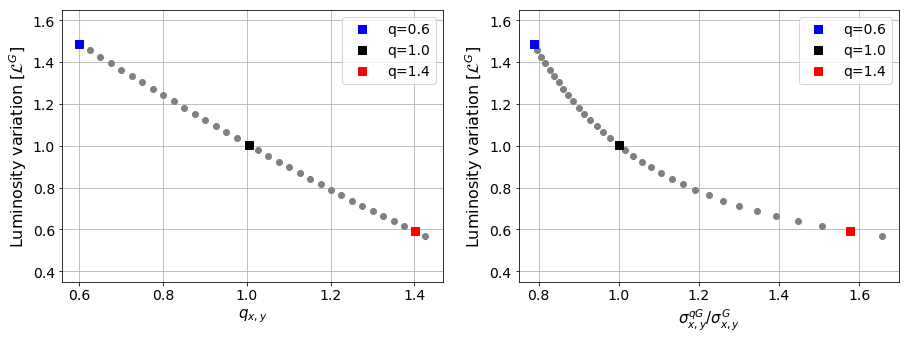

In [73]:
fig1 = plt.figure('B1 extra', figsize=(15,5))
ax_1 = plt.subplot(122)
ax_2 = plt.subplot(121)

cmap = matplotlib.cm.get_cmap('viridis')

#mpla=np.where(qGx==na(qq))[0][0].tolist()

#themin=min(min(lumi_qG_trans))*1e-34
#themax=max(max(lumi_qG_trans))*1e-34
themin=min(min(lumi_qG_tl))*1e-34/(pLumi*1e-34)
themax=max(max(lumi_qG_tl))*1e-34/(pLumi*1e-34)

mpex=np.where(qGx==na(qq))[0]
mpeex=mpex.tolist()[0]

mpe=np.where(qGz==na(qq))[0]
mpee=mpe.tolist()[0]

xx=[]
zz=[]
for j in range(0,len(lumi_qG_tl)):
    xx.append(sigma_qG_t[j]/sigma_qG_t[mpeex])
    zz.append(lumi_qG_tl[j][0]*1e-34/(pLumi*1e-34))
ax_1.plot(xx, zz,'o', color='grey')
ax_1.plot(xx[0], zz[0],'sb',markersize=8,label='q=0.6')
ax_1.plot(xx[16], zz[16],'sk',markersize=8,label='q=1.0')
ax_1.plot(xx[-2], zz[-2],'sr',markersize=8,label='q=1.4')
ax_1.set_ylabel('Luminosity variation [$\cal{L}$$^G$]',fontsize=16)

xx=[]
zz=[]
for j in range(0,len(lumi_qG_tl)):
    xx.append(qGx[j])
    zz.append(lumi_qG_tl[j][0]*1e-34/(pLumi*1e-34))
ax_2.plot(xx, zz,'o', color='grey')
ax_2.plot(xx[0], zz[0],'sb',markersize=8,label='q=0.6')
ax_2.plot(xx[16], zz[16],'sk',markersize=8,label='q=1.0')
ax_2.plot(xx[-2], zz[-2],'sr',markersize=8,label='q=1.4')
ax_2.set_ylabel('Luminosity variation [$\cal{L}$$^G$]',fontsize=16)

ax_1.set_xlabel('$\sigma^{qG}_{x,y}/\sigma^{G}_{x,y}$', fontsize=15)
ax_2.set_xlabel('$q_{x,y}$', fontsize=15)

plt.setp(ax_1.get_yticklabels(), fontsize=14)
plt.setp(ax_1.get_xticklabels(), fontsize=14)
plt.setp(ax_2.get_yticklabels(), fontsize=14)
plt.setp(ax_2.get_xticklabels(), fontsize=14)

ax_1.legend(loc='upper right', fontsize=14, numpoints=1)
ax_2.legend(loc='upper right', fontsize=14, numpoints=1)

ax_1.set_ylim(0.35,1.65)
ax_2.set_ylim(0.35,1.65)

ax_1.set_xlim(0.75,1.7)
#ax_2.set_ylim(0.35,1.65)

ax_1.grid('on')
ax_2.grid('on')

plt.show()

## rms constant, varying q, b

In [74]:
#transverse qGauss and longitudinal qGauss
qq=1.006;
#bbx=1.79e-4;bby=bbx;bbz=2.557074e-12;
#bbx=1.79e-3;bby=bbx
#bbz=2.557075e-11
#print frev,Npart,phi
#sigma_G=np.sqrt(1./(beta_param*(5.0-3.0*1)))*1e-4
#exx=sigma
#enx_qG=enx;(sigma_qG)**2/bx*gamma
#sigma_qG_t=[]
q_param=np.array(range(601,1451,25))/1000.0
#q_param
lumi_qG_tl=[]
qGx=[]
bGx=[]
#for qz in 
sigma_G=np.sqrt(bx*enx/gama)
for qx in q_param:
    bbx=1./(sigma_G**2*(5.0-3.0*qx))
    #if (qx<1.006 and qx>=1):
    #    qx=qq
    #elif (qx<=1 and qx>0.999):    
    #    qx=0.998
    bby=bbx
    qy=qx
    #sigmaX_qG=np.sqrt(1./(bbx*(5.0-3.0*qx)))
    #sigma_qG_t.append(sigmaX_qG)
    #sigma_qG_l=[]
    lumi_qGz=[]
    qGz=[]
    bGz=[]
    for qz in q_param:  
        bbz=1./((blength/4*clight)**2*(5.0-3.0*qz))
        #if (qz<1.006 and qz>=1):
        #    qz=qq
        #elif (qz<=1 and qz>0.999):    
        #    qz=0.998
        #sigmaZ_qG=np.sqrt(1./(bbz*(5.0-3.0*qz)))
        #print sigmaZ_qG
        #sigma_qG_l.append(sigmaZ_qG)
        lumi_qG=luminosity_3DqGauss( qx=qx,qy=qy,qz=qz, bbx=bbx,bby=bby,bbz=bbz, Npart_ppb=Npart, nb=nb, frev_hz=frev, phi_rad=phi)
        lumi_qGz.append(float((lumi_qG)[0]))
        qGz.append(qz)
        bGz.append(bbz)
        #print qy,lumi_qGy
    qGx.append(qx)    
    bGx.append(bbx)
    lumi_qG_tl.append(lumi_qGz)
    #print qx, lumi_qG_tl[0]
bbx=bbx_g;bby=bbx;bbz=bbz_g;     

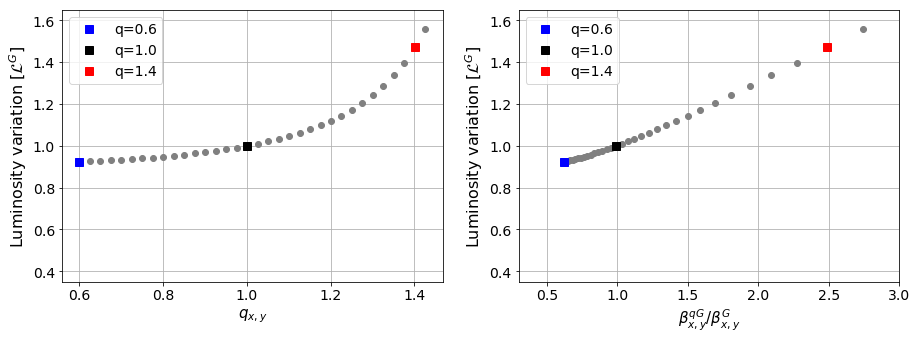

In [75]:
fig1 = plt.figure('B1 extra', figsize=(15,5))
ax_1 = plt.subplot(122)
ax_2 = plt.subplot(121)

xx=[]
zz=[]
for j in range(0,len(lumi_qG_tl)):
    xx.append(bGx[j]/bbx)
    zz.append(lumi_qG_tl[j][0]*1e-34/(pLumi*1e-34))
ax_1.plot(xx, zz,'o', color='grey')
ax_1.plot(xx[0], zz[0],'sb',markersize=8,label='q=0.6')
ax_1.plot(xx[16], zz[16],'sk',markersize=8,label='q=1.0')
ax_1.plot(xx[-2], zz[-2],'sr',markersize=8,label='q=1.4')
ax_1.set_ylabel('Luminosity variation [$\cal{L}$$^G$]',fontsize=16)

xx=[]
zz=[]
for j in range(0,len(lumi_qG_tl)):
    xx.append(qGx[j])
    zz.append(lumi_qG_tl[j][0]*1e-34/(pLumi*1e-34))
ax_2.plot(xx, zz,'o', color='grey')
ax_2.plot(xx[0], zz[0],'sb',markersize=8,label='q=0.6')
ax_2.plot(xx[16], zz[16],'sk',markersize=8,label='q=1.0')
ax_2.plot(xx[-2], zz[-2],'sr',markersize=8,label='q=1.4')

ax_2.set_ylabel('Luminosity variation [$\cal{L}$$^G$]',fontsize=16)

ax_1.set_xlabel(r'$\beta^{qG}_{x,y}/\beta^{G}_{x,y}$', fontsize=15)
ax_2.set_xlabel('$q_{x,y}$', fontsize=15)

plt.setp(ax_1.get_yticklabels(), fontsize=14)
plt.setp(ax_1.get_xticklabels(), fontsize=14)
plt.setp(ax_2.get_yticklabels(), fontsize=14)
plt.setp(ax_2.get_xticklabels(), fontsize=14)

ax_1.set_ylim(0.35,1.65)
ax_2.set_ylim(0.35,1.65)

ax_1.set_xlim(0.3,3)

ax_1.grid('on')
ax_2.grid('on')

ax_1.legend(loc='upper left', fontsize=14, numpoints=1)
ax_2.legend(loc='upper left', fontsize=14, numpoints=1)

plt.show()

### for both planes now

In [76]:
#transverse qGauss and longitudinal qGauss
qq=1.006;
qz=1.006;
bbz=bbz_g;

#bbx=1.79e-4;bby=bbx;bbz=2.557074e-12;
#bbx=1.79e-3;bby=bbx
#bbz=2.557075e-11
#print frev,Npart,phi
#sigma_G=np.sqrt(1./(beta_param*(5.0-3.0*1)))*1e-4
#exx=sigma
#enx_qG=enx;(sigma_qG)**2/bx*gamma
#sigma_qG_t=[]
q_param=np.array(range(601,1451,10))/1000.0
#q_param=np.array(range(-1000,1666,50))/1000.0
#q_param
lumi_qG_tl=[]
qGx=[]
bGx=[]
#for qz in 
sigma_G=np.sqrt(bx*enx/gama)
for qx in q_param:
    bbx=1./(sigma_G**2*(5.0-3.0*qx))
    #if (qx<1.006 and qx>=1):
    #    qx=qq
    #elif (qx<=1 and qx>0.999):    
    #    qx=0.998
    #bby=bbx
    #qy=qx
    #sigmaX_qG=np.sqrt(1./(bbx*(5.0-3.0*qx)))
    #sigma_qG_t.append(sigmaX_qG)
    #sigma_qG_l=[]
    lumi_qGz=[]
    qGy=[]
    bGy=[]
    for qy in q_param:  
        bby=1./(sigma_G**2*(5.0-3.0*qy))
        #if (qz<1.006 and qz>=1):
        #    qz=qq
        #elif (qz<=1 and qz>0.999):    
        #    qz=0.998
        #sigmaZ_qG=np.sqrt(1./(bbz*(5.0-3.0*qz)))
        #print sigmaZ_qG
        #sigma_qG_l.append(sigmaZ_qG)
        lumi_qG=luminosity_3DqGauss( qx=qx,qy=qy,qz=qz, bbx=bbx,bby=bby,bbz=bbz, Npart_ppb=Npart, nb=nb, frev_hz=frev, phi_rad=phi)
        lumi_qGz.append(float((lumi_qG)[0]))
        qGy.append(qy)
        bGy.append(bby)
        #print qy,lumi_qGy
    qGx.append(qx)    
    bGx.append(bbx)
    lumi_qG_tl.append(lumi_qGz)
    #print qx, lumi_qG_tl[0]
bbx=bbx_g;bby=bbx;bbz=bbz_g;     

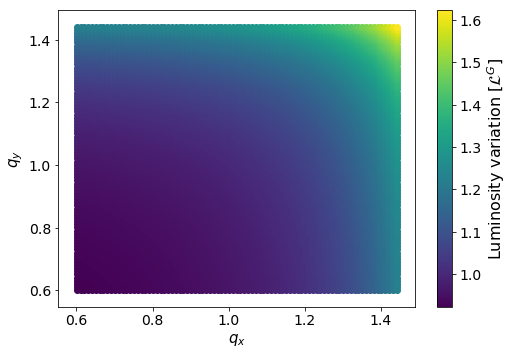

In [78]:
fig1 = plt.figure('mpla', figsize=(8,12))
ax_1 = plt.subplot(211)
#ax_2 = plt.subplot(212)

cmap = matplotlib.cm.get_cmap('viridis')

#mpla=np.where(qGx==na(qq))[0][0].tolist()

#themin=min(min(lumi_qG_trans))*1e-34
#themax=max(max(lumi_qG_trans))*1e-34
themin=min(min(lumi_qG_tl))*1e-34/(pLumi*1e-34)
themax=max(max(lumi_qG_tl))*1e-34/(pLumi*1e-34)

for j in range(0,len(lumi_qG_tl)):
    xx=qGx[j]
    #print j
    zz=na(lumi_qG_tl[j])*1e-34/(pLumi*1e-34)
    
    normalize = matplotlib.colors.Normalize(vmin=themin, vmax=themax)
    colors = [cmap(normalize(value)) for value in np.array(zz)]
    for i in range(0,len(qGy)):
        #print colors[i]
        #print i
        yy=qGy[i]
        #zz=zzz[i]  
        ax_1.scatter(xx, yy, color=colors[i])
#ax_1.scatter(0.6, 0.6, s=400,facecolors='b', edgecolors='w', marker="*")        
#ax_1.scatter(1, 1, s=400,facecolors='k', edgecolors='w', marker="*")
#ax_1.scatter(1.4, 1.4, s=400,facecolors='r', edgecolors='w', marker="*")
cax, _ = matplotlib.colorbar.make_axes(ax_1)
cbar1 = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
cbar1.set_label(label='Luminosity variation [$\cal{L}$$^G$]',fontsize=16)
cbar1.ax.tick_params(labelsize=14)

ax_1.set_xlabel('$q_x$', fontsize=15)
ax_1.set_ylabel('$q_y$', fontsize=15)

#ax_2.set_xlabel('$q_{x,y}$', fontsize=15)
#ax_2.set_ylabel('$q_{s}$', fontsize=15)

plt.setp(ax_1.get_yticklabels(), fontsize=14)
plt.setp(ax_1.get_xticklabels(), fontsize=14)
#plt.setp(ax_2.get_yticklabels(), fontsize=14)
#plt.setp(ax_2.get_xticklabels(), fontsize=14)
plt.show() 

## q constant, varying b,rms

In [79]:
#transverse qGauss and longitudinal qGauss
qq=1.006;qx=qq;qy=qq;qz=qq;

sigma_G=np.sqrt(bx*enx/gama)
#sigma_G=np.sqrt(1./(beta_param*(5.0-3.0*1)))*1e-4
#exx=sigma
#enx_qG=enx;(sigma_qG)**2/bx*gamma
sigma_qG_t=[]

s_param=np.array(range(860,1780,20))/1e8
sl_param=np.array(range(6550,13700,195))/1e5
#q_param
lumi_qG_tl=[]
bGx=[]

#for qz in 
#sigma_G=np.sqrt(bx*enx/gama)
for sigmaX_qG in s_param:
    bbx=1./(sigmaX_qG**2*(5.0-3.0*qx))
    bby=bbx
    #qy=qx
    #sigmaX_qG=np.sqrt(1./(bbx*(5.0-3.0*qx)))
    sigma_qG_t.append(sigmaX_qG)
    sigma_qG_l=[]
    lumi_qGz=[]
    bGz=[]
    for sigmaZ_qG in sl_param:   
        sigmaZ_qG=(blength/4*clight)
        bbz=1./(sigmaZ_qG**2*(5.0-3.0*qz))
        #print qz,sigmaZ_qG,bbz
        bGz.append(bbz)
        #sigmaZ_qG=np.sqrt(1./(bbz*(5.0-3.0*qz)))
        sigma_qG_l.append(sigmaZ_qG)
        lumi_qG=luminosity_3DqGauss(qx=qq,qy=qq,qz=qq, bbx=bbx,bby=bby,bbz=bbz, Npart_ppb=Npart, nb=nb, frev_hz=frev, phi_rad=phi)
        lumi_qGz.append(float((lumi_qG)[0]))
        
        #print qy,lumi_qGy  
    bGx.append(bbx)    
    lumi_qG_tl.append(lumi_qGz)
    
bbx=bbx_g;bby=bby_g;bbz=bbz_g;      

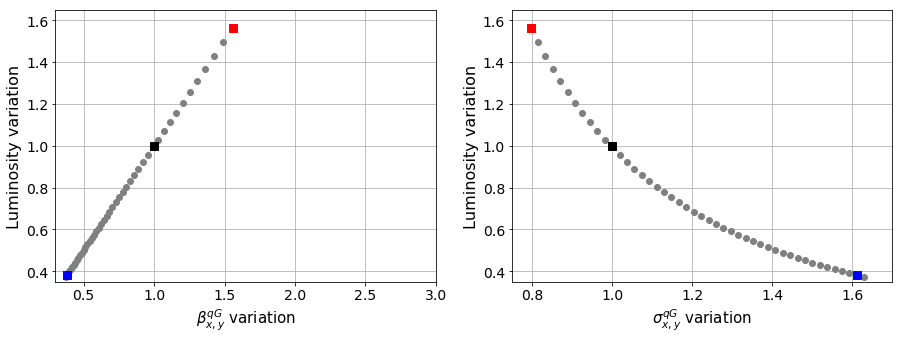

In [80]:
fig1 = plt.figure('B1 extra', figsize=(15,5))
ax_2 = plt.subplot(122)
ax_1 = plt.subplot(121)

#mpex=np.where(sigma_qG_t==na(sigma_G))[0]
#mpeex=mpex.tolist()[0]
mpeex=11
#mpe=np.where(sigma_qG_l==na(blength))[0]
#mpee=mpe.tolist()[0]
mpee=9

xx=[]
zz=[]
for j in range(0,len(lumi_qG_tl)):
    xx.append(bGx[j]/bbx)
    zz.append(lumi_qG_tl[j][0]*1e-34/(pLumi*1e-34))
ax_1.plot(xx, zz,'o', color='grey')
ax_1.plot(xx[0], zz[0],'sr',markersize=8)#,label='$\sigma$=0.8')
ax_1.plot(1., 1.,'sk',markersize=8)#,label='$\sigma$=1.0')
ax_1.plot(xx[-2], zz[-2],'sb',markersize=8)#,label='$\sigma$=1.4')
ax_1.set_ylabel('Luminosity variation',fontsize=16)

xx=[]
zz=[]
for j in range(0,len(lumi_qG_tl)):
    xx.append(sigma_qG_t[j]/sigma_qG_t[mpeex])
    zz.append(lumi_qG_tl[j][0]*1e-34/(pLumi*1e-34))
ax_2.plot(xx, zz,'o', color='grey')
ax_2.plot(xx[0], zz[0],'sr',markersize=8)#,l)#abel=r'$\beta$=0.8')
ax_2.plot(1., 1.,'sk',markersize=8)#,label=r'$\beta$=0.8')
ax_2.plot(xx[-2], zz[-2],'sb',markersize=8)#,label=r'$\beta$=0.8')

ax_2.set_ylabel('Luminosity variation',fontsize=16)

#ax_1.set_xlabel(r'$\beta^{qG}_{x,y}/\beta^{G}_{x,y}$', fontsize=15)
#ax_2.set_xlabel('$\sigma^{qG}_{x,y}/\sigma^{G}_{x,y}$', fontsize=15)

ax_1.set_xlabel(r'$\beta^{qG}_{x,y}$ variation', fontsize=15)
ax_2.set_xlabel('$\sigma^{qG}_{x,y}$ variation', fontsize=15)


ax_1.set_ylim(0.35,1.65)
ax_2.set_ylim(0.35,1.65)

ax_1.set_xlim(0.3,3)
ax_2.set_xlim(0.75,1.7)

plt.setp(ax_1.get_yticklabels(), fontsize=14)
plt.setp(ax_1.get_xticklabels(), fontsize=14)
plt.setp(ax_2.get_yticklabels(), fontsize=14)
plt.setp(ax_2.get_xticklabels(), fontsize=14)

ax_1.grid('on')
ax_2.grid('on')

#ax_1.legend(loc='upper left', fontsize=14, numpoints=1)
#ax_2.legend(loc='upper right', fontsize=14, numpoints=1)

plt.show()

## test the q-Gaussian luminosity formula for Gaussian distributions (the usual formula)

In [81]:
sigma_Gt=[]
#sigma_Gl=[]

sigma_G=np.sqrt(bx*enx/gama)
#tparam=np.array(range(70,125,5))/100000.0#range(0.82*sigma_G,1.3*sigma_G)
#lparam=np.array(range(88,145,5))/1e11

tparam=np.array(range(860,1780,20))/1e8
lparam=np.array(range(8500,18300,200))/1e13

#s_param=np.array(range(860,1780,20))/1e8
#sl_param=np.array(range(6550,13700,195))/1e5

#q_param
lumi_G=[]

#for qz in 
for ttt in tparam:
    emit=ttt**2/bx*gama
    sigma_Gt.append(ttt)
    lumi_Gz=[]
    for lll in lparam:    
        #bunlen=lll
        bunlen=blength
        pLumiG = luminosity(gama=gama,bx_m=bx, by_m=bx, enx_m=emit, eny_m=emit, Npart_ppb=Npart, nb=nb, frev_hz=frev, blength_s=bunlen, phi_rad=phi, experiment='CMS', crab=False)
        lumi_Gz.append(pLumiG)
        #print qy,lumi_qGy   
    lumi_G.append(lumi_Gz)       

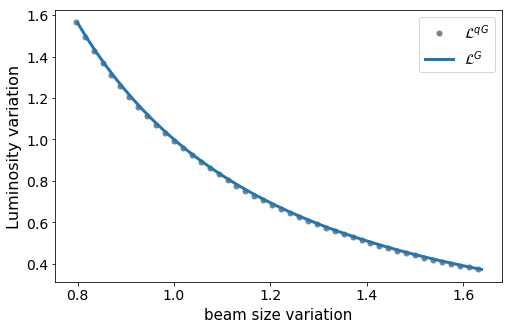

"\nfig = plt.figure('', figsize=(8,4))\n\nxxg=[]\nzzg=[]\nfor j in range(0,len(lumi_G)):\n    xxg.append(sigma_Gt[j]/sigma_G)\n    zzg.append(lumi_G[j][0]*1e-34/(pLumi*1e-34))\nplt.plot(xx, na(zz)/na(zzg),'.', color='grey', label='$\\cal{L}$$^{qG}$')    \n#plt.plot(xxg,zzg,'-', label='$\\cal{L}$$^{G}$')\nplt.legend(loc='upper right', fontsize=14, numpoints=1)\nplt.ylabel('Luminosity variation',fontsize=16)\nplt.xlabel('$\\sigma^{qG}_{x,y}/\\sigma^{G}_{x,y}$', fontsize=15)\nplt.show()\n"

In [86]:
fig = plt.figure('', figsize=(8,5))

xxg=[]
zzg=[]
for j in range(0,len(lumi_G)):
    xxg.append(sigma_Gt[j]/sigma_G)
    zzg.append(lumi_G[j][0]*1e-34/(pLumi*1e-34))
plt.plot(xx, zz,'.', color='grey',Markersize=10, label='$\cal{L}$$^{qG}$')    
plt.plot(xxg,zzg,'-',Linewidth=3, label='$\cal{L}$$^{G}$')
plt.legend(loc='upper right', fontsize=14, numpoints=1)
plt.ylabel('Luminosity variation',fontsize=16)
plt.xlabel('beam size variation', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.show()

'''
fig = plt.figure('', figsize=(8,4))

xxg=[]
zzg=[]
for j in range(0,len(lumi_G)):
    xxg.append(sigma_Gt[j]/sigma_G)
    zzg.append(lumi_G[j][0]*1e-34/(pLumi*1e-34))
plt.plot(xx, na(zz)/na(zzg),'.', color='grey', label='$\cal{L}$$^{qG}$')    
#plt.plot(xxg,zzg,'-', label='$\cal{L}$$^{G}$')
plt.legend(loc='upper right', fontsize=14, numpoints=1)
plt.ylabel('Luminosity variation',fontsize=16)
plt.xlabel('$\sigma^{qG}_{x,y}/\sigma^{G}_{x,y}$', fontsize=15)
plt.show()
'''